This code will parse all ALTO XML files inside your specified path, extract text block by block (with metadata), and return a clean DataFrame

It creates a .txt file in the "exports" folder

In [4]:
import xml.etree.ElementTree as ET
from pathlib import Path
from tqdm import tqdm

# ---- Config: WSL paths only (Linux-style) ----
# You can point this at a MONTH (YYYY/MM) or a YEAR (YYYY) to process everything under it
month_root = Path("/home/acr1408/projects/portafolio/der_tag/data/dertag_1918-1920/dertagcopy/1918")
output_dir = Path("/home/acr1408/projects/portafolio/der_tag/data/dertag_1918-1920/exports")  # <-- FIXED root for exports
output_dir.mkdir(parents=True, exist_ok=True)

# --- OCR normalizer: map long s (ſ, U+017F) to normal s ---
def normalize_ocr_text(s: str) -> str:
    # fast and safe for any input string
    return s.translate(str.maketrans({"ſ": "s"}))

def _detect_alto_namespace(root) -> dict:
    """
    Detect the default ALTO namespace from the root tag.
    Falls back to v4 if not present. Works with v2/v3/v4.
    """
    tag = root.tag  # e.g. "{http://...ns-v3#}alto"
    if tag.startswith("{") and "}" in tag:
        uri = tag[1:tag.index("}")]
        return {"alto": uri}
    # Fallback: common v4 namespace
    return {"alto": "http://www.loc.gov/standards/alto/ns-v4#"}

def parse_alto_file_for_issue(filepath: Path):
    """
    Return a list of (page_no_int, block_order_int, text) for a single ALTO XML file.
    We keep the original order of blocks as they appear in the file.
    """
    out = []
    try:
        tree = ET.parse(filepath)
        root = tree.getroot()
        NS = _detect_alto_namespace(root)

        pages = root.findall('.//alto:Page', NS)

        for page_idx, page in enumerate(pages):
            # Prefer PHYSICAL_IMG_NR; fall back to page_idx+1 if missing
            page_no_raw = page.get('PHYSICAL_IMG_NR', '')
            try:
                page_no = int(page_no_raw)
            except (TypeError, ValueError):
                page_no = page_idx + 1

            print_space = page.find('.//alto:PrintSpace', NS)
            if print_space is None:
                continue

            text_blocks = print_space.findall('.//alto:TextBlock', NS)

            # Preserve the file order of blocks
            for block_order, block in enumerate(text_blocks):
                lines = []
                for line in block.findall('.//alto:TextLine', NS):
                    strings = line.findall('alto:String', NS)
                    # Normalize each token's CONTENT so ſ -> s before joining
                    words = [
                        normalize_ocr_text(s.get('CONTENT'))
                        for s in strings if s.get('CONTENT')
                    ]
                    if words:
                        lines.append(' '.join(words))
                full_text = '\n'.join(lines).strip()
                if full_text:
                    out.append((page_no, block_order, full_text))
    except Exception as e:
        print(f"❌ Error in file {filepath}: {e}")
    return out

def issue_parts_from_fulltext_dir(fulltext_dir: Path):
    """
    Expect path like .../<year>/<month>/<day>/<issue>/fulltext
    Returns (year, month, day, issue) as strings, and a uid like 'YYYY-MM-DD-iII'.
    """
    if not fulltext_dir.exists():
        raise FileNotFoundError(f"Fulltext directory not found: {fulltext_dir}")
    if not fulltext_dir.is_dir():
        raise NotADirectoryError(f"Not a directory: {fulltext_dir}")

    parts = fulltext_dir.parts
    if 'fulltext' not in parts:
        raise ValueError(f"'fulltext' not in path: {fulltext_dir}")
    i = parts.index('fulltext')
    try:
        year, month, day, issue = parts[i-4:i]
    except Exception:
        raise ValueError(f"Path does not look like .../YYYY/MM/DD/II/fulltext: {fulltext_dir}")
    uid = f"{year}-{month}-{day}-i{issue}"
    return year, month, day, issue, uid

def build_issue_text(fulltext_dir: Path):
    """
    Aggregate all XMLs in one issue's fulltext dir into a single ordered text string.
    Order: page number (numeric) ascending, then block order.
    Inserts simple page separators.
    """
    if not fulltext_dir.exists():
        raise FileNotFoundError(f"Fulltext directory not found: {fulltext_dir}")

    xml_files = sorted(fulltext_dir.glob("*.xml"))  # sort filenames for stability

    if not xml_files:
        raise FileNotFoundError(f"No .xml files found in: {fulltext_dir}")

    records = []
    for xf in tqdm(xml_files, desc="Reading ALTO XML for issue"):
        recs = parse_alto_file_for_issue(xf)
        records.extend(recs)

    if not records:
        # No text extracted; return empty string to still write an empty file if desired
        return ""

    # sort by page number then block order
    records.sort(key=lambda t: (t[0], t[1]))

    # Build text with page headers
    output_lines = []
    current_page = None
    for page_no, block_order, text in records:
        if page_no != current_page:
            if current_page is not None:
                output_lines.append("")  # blank line between pages
            output_lines.append(f"=== PAGE {page_no} ===")
            output_lines.append("")
            current_page = page_no
        output_lines.append(text)
        output_lines.append("")  # blank line between blocks

    return "\n".join(output_lines).strip()

# ---- Run for ALL issues under the chosen root (month or year) ----
fulltext_dirs = sorted(p for p in month_root.rglob("fulltext") if p.is_dir())
if not fulltext_dirs:
    raise FileNotFoundError(f"No 'fulltext' dirs found under: {month_root}")

ok, failed = 0, 0
for ft_dir in tqdm(fulltext_dirs, desc=f"Processing issues in {month_root}"):
    try:
        year, month, day, issue, uid = issue_parts_from_fulltext_dir(ft_dir)
        issue_text = build_issue_text(ft_dir)

        # Keep outputs grouped by year/month for neatness
        out_dir = output_dir / year / month
        out_dir.mkdir(parents=True, exist_ok=True)

        out_path = out_dir / f"{uid}.txt"  # e.g. 1918/01/1918-01-01-i01.txt
        out_path.write_text(issue_text, encoding="utf-8")
        ok += 1
    except Exception as e:
        print(f"❌ Skipping {ft_dir}: {e}")
        failed += 1

print(f"✅ Wrote {ok} issue file(s). ❗ Failed: {failed}.")


Processing issues in /home/acr1408/projects/portafolio/der_tag/data/dertag_1918-1920/dertagcopy/1918:   0%| | 0/933 [00:00<?
Reading ALTO XML for issue: 100%|█████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.59it/s]
Processing issues in /home/acr1408/projects/portafolio/der_tag/data/dertag_1918-1920/dertagcopy/1918:   0%| | 1/933 [00:01<1
Reading ALTO XML for issue: 100%|█████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 13.06it/s]
Processing issues in /home/acr1408/projects/portafolio/der_tag/data/dertag_1918-1920/dertagcopy/1918:   0%| | 2/933 [00:01<1
Reading ALTO XML for issue: 100%|█████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.76it/s]
Processing issues in /home/acr1408/projects/portafolio/der_tag/data/dertag_1918-1920/dertagcopy/1918:   0%| | 3/933 [00:02<0
Reading ALTO XML for issue: 100%|█████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 16.38it/s]


- Mistral models were gated and I couldn't used them
- Qwen required too much memory so it caused the Kernel to interrupt
- flat-t5-base was too small to deal with all the token that are needed for each newspaper article

In [1]:
#!pip install requests

In [1]:
#!pip install "openai>=1.0.0" tqdm pandas

In [5]:
# issues_topics_openrouter_api_only.py
# Extract topics per issue (.txt) -> CSV, using ONLY OpenRouter (Claude) via the OpenAI-compatible API.
# No local topic modeling, no embeddings, no sklearn, no BERTopic.

from pathlib import Path
import re
import os
import math
import pandas as pd
from tqdm import tqdm
from openai import OpenAI

# ======================== CONFIG ========================
EXPORTS_ROOT = Path("/home/acr1408/projects/portafolio/der_tag/data/dertag_1918-1920/exports")
CSV_OUT      = EXPORTS_ROOT / "issues_topics_llm.csv"

# OpenRouter model + auth (set env vars before running)
#OPENROUTER_MODEL   = os.getenv("OPENROUTER_MODEL", "anthropic/claude-3-haiku")
OPENROUTER_MODEL   = os.getenv("OPENROUTER_MODEL", "ameta-llama/llama-3.3-70b-instruct:free")
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY", "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")

# How many lightweight keywords & doc snippets to pass into the prompt
N_KEYWORDS        = 12
N_DOC_SNIPPETS    = 3
SNIPPET_WORDS     = 64

# Max chars we try to include in a single API request (very conservative)
MAX_PROMPT_CHARS  = 12000

# ======================== PROMPT (yours) ========================
LLM_PROMPT_TMPL = (
    "You are a historian researcher analyzing German newspapers published between 1900 and 1934. "
    "Your task is to extract the main historical topics discussed in the issue.\n\n"
    "Instructions:\n"
    "1. Identify all relevant historical themes (political, social, cultural, economic, or international).\n"
    "2. Extract at least 5 distinct topics that best represent the newspaper’s content.\n"
    "3. Even if the text is in German, write the extracted topics clearly in English.\n"
    "4. Each topic should be concise (3–5 words) and reflect historically meaningful subjects — "
    "not just keywords.\n"
    "5. Examples: 'Debate on Labor Reforms', 'Rise of Nationalism', 'Cultural Life in Berlin'.\n\n"
    "Keywords: [KEYWORDS]\n"
    "Documents: [DOCUMENTS]\n\n"
    "Extracted Topics (in English):"
)

# ======================== SIMPLE HELPERS (no ML) ========================
def parse_issue_from_path(p: Path):
    """Parse YYYY-MM-DD-iII from filename and year/month from dirs if present."""
    m = re.search(r"(?P<y>\d{4})-(?P<m>\d{2})-(?P<d>\d{2})-i(?P<i>\d+)\.txt$", p.name)
    if m:
        return m.group("y"), m.group("m"), m.group("d"), m.group("i")
    parts = p.parts
    year = next((x for x in parts if re.fullmatch(r"\d{4}", x)), "")
    month = next((x for x in parts if re.fullmatch(r"\d{2}", x)), "")
    daym = re.search(r"\d{4}-(\d{2})-(\d{2})", p.name)
    day  = daym.group(2) if daym else ""
    issue = (re.search(r"-i(\d+)", p.name) or re.search(r"i(\d+)", p.name) or [None, ""])[1]
    return year, month, day, issue

def split_into_docs(raw_text: str):
    """
    Heuristic chunking to make short representative snippets (no ML):
    - Prefer page headers '=== PAGE N ==='
    - Else split on blank lines
    - Else sentence windows
    """
    if "=== PAGE" in raw_text:
        chunks = re.split(r"^=== PAGE .*?===$", raw_text, flags=re.MULTILINE)
    else:
        chunks = re.split(r"\n\s*\n", raw_text)

    docs = [re.sub(r"\s+", " ", c).strip() for c in chunks]
    docs = [d for d in docs if len(d) >= 200]

    if len(docs) < 3:
        sents = re.split(r"(?<=[.!?])\s+", raw_text)
        window, step = 5, 5
        docs = []
        for i in range(0, len(sents), step):
            piece = " ".join(sents[i:i+window]).strip()
            if len(piece) >= 150:
                docs.append(piece)
    return docs

# a tiny German/English stopword list (keep it minimal; we avoid external deps)
_STOP = set("""
der die das ein eine eines einer einem einen und oder aber denn sondern
zu zum zur von vom vor nach über unter mit ohne für auf aus bei durch gegen
ist sind war waren wird werden sein haben hatte hatten hat
in im ins am an als auch noch nur schon sehr mehr weniger
ich du er sie es wir ihr sie
the a an and or but for of on in at by from to into over under with without
""".split())

def top_keywords_simple(text: str, k: int = 12):
    # super-lightweight tokenizer + frequency counter
    tokens = re.findall(r"[A-Za-zÄÖÜäöüß\-]{3,}", text)
    counts = {}
    for t in tokens:
        t_low = t.lower()
        if t_low in _STOP:
            continue
        counts[t_low] = counts.get(t_low, 0) + 1
    items = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    return [w for w, _ in items[:k]]

def snippetize(docs, n=3, words=64):
    # choose up to n evenly spaced doc snippets, truncated to N words
    if not docs:
        return []
    idxs = [0]
    if len(docs) > 1:
        idxs.append(len(docs)//2)
    if len(docs) > 2:
        idxs.append(len(docs)-1)
    idxs = idxs[:n]
    out = []
    for i in idxs:
        toks = docs[i].split()
        out.append(" ".join(toks[:words]))
    return out

def trim_for_prompt(s: str, limit: int) -> str:
    return s if len(s) <= limit else s[:limit]

def parse_topics_list(text: str):
    """Return a list of concise topics from model output."""
    lines = [ln.strip("-* \t\r\n") for ln in text.splitlines()]
    lines = [re.sub(r"^\d+\.\s*", "", ln).strip() for ln in lines if ln.strip()]
    # Keep 3–6 words per item, drop long rambles
    cleaned = []
    for ln in lines:
        words = ln.split()
        if 2 <= len(words) <= 8:
            cleaned.append(ln.rstrip(".,:;—-"))
    # If nothing matched, fall back to first 5 non-empty lines
    if not cleaned:
        cleaned = [ln for ln in lines][:5]
    # Keep at most 10 topics
    return cleaned[:10]

# ======================== OpenRouter (OpenAI-compatible) ========================
if not OPENROUTER_API_KEY:
    raise SystemExit("OPENROUTER_API_KEY not set. Export it before running.")

client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=OPENROUTER_API_KEY,
)

def call_claude(keywords, snippets):
    kw   = ", ".join(keywords) if keywords else "N/A"
    docs = "\n\n".join(f"- {s}" for s in snippets) if snippets else "N/A"

    # Build the historian prompt with placeholders
    prompt = LLM_PROMPT_TMPL.replace("[KEYWORDS]", kw).replace("[DOCUMENTS]", docs)
    prompt = trim_for_prompt(prompt, MAX_PROMPT_CHARS)

    resp = client.chat.completions.create(
        model=OPENROUTER_MODEL,  # e.g., "anthropic/claude-3-haiku"
        messages=[
            {
                "role": "system",
                "content": (
                    "Return ONLY the list of extracted topics in English, one per line, "
                    "no extra commentary."
                ),
            },
            {"role": "user", "content": prompt},
        ],
        temperature=0.6,
        top_p=0.95,
        max_tokens=256,
    )
    out = (resp.choices[0].message.content or "").strip()
    return parse_topics_list(out)

# ======================== Main loop (API-only) ========================
txt_paths = sorted(EXPORTS_ROOT.rglob("*.txt"))
if not txt_paths:
    raise FileNotFoundError(f"No .txt issues found under: {EXPORTS_ROOT}")

rows = []

for p in tqdm(txt_paths, desc="Extracting topics (Claude via OpenRouter)"):
    year, month, day, issue = parse_issue_from_path(p)
    text = p.read_text(encoding="utf-8", errors="ignore")

    # Light preprocessing only (no ML):
    docs = split_into_docs(text)
    # super-light keywords (no sklearn)
    kws = top_keywords_simple(text, k=N_KEYWORDS)
    # a few short document snippets
    snippets = snippetize(docs, n=N_DOC_SNIPPETS, words=SNIPPET_WORDS)

    # Call Claude via OpenRouter to get topics
    topics = call_claude(kws, snippets)

    # If API returned nothing, fall back to very crude keywords as topics
    if not topics:
        topics = kws[:5]

    # For CSV compatibility, we’ll mirror Topics into Subtopics (or take first 5)
    subtopics = topics[:5] if topics else kws[:5]

    rows.append({
        "year": year, "month": month, "day": day, "issue": issue,
        "topics": "|".join(topics[:5]),       # keep top 5
        "subtopics": "|".join(subtopics[:5]), # keep top 5
        "path": str(p)
    })

df = pd.DataFrame(rows, columns=["year", "month", "day", "issue", "topics", "subtopics", "path"])
df.sort_values(["year", "month", "day", "issue"], inplace=True)
df.to_csv(CSV_OUT, index=False, encoding="utf-8")
print(f"✅ Wrote topics CSV -> {CSV_OUT}")


Extracting topics (Claude via OpenRouter):  32%|█████████████▎                            | 296/934 [05:39<12:10,  1.15s/it]


APIStatusError: Error code: 402 - {'error': {'message': 'Insufficient credits. This account never purchased credits. Make sure your key is on the correct account or org, and if so, purchase more at https://openrouter.ai/settings/credits', 'code': 402}}

In [11]:
from pathlib import Path
import pandas as pd

# 1) Search for CSVs anywhere under your project root
project_root = Path("/home/acr1408/projects/portafolio/der_tag")
csv_files = list(project_root.rglob("*.csv"))
print(f"Found {len(csv_files)} CSVs")
# Peek a few
for p in csv_files[:10]:
    print(p)

# 2) Prefer the 'exports' dir if present
exports_dirs = sorted({p.parent for p in csv_files if "exports" in str(p.parent)})
if exports_dirs:
    data_dir = str(exports_dirs[0])  # pick the first exports folder found
else:
    # fallback: use the directory that has the most CSVs
    from collections import Counter
    counts = Counter(p.parent for p in csv_files)
    data_dir = str(counts.most_common(1)[0][0]) if counts else None

if not data_dir:
    raise FileNotFoundError("No CSV files found anywhere under the project root. "
                            "Check that your exports exist and end with .csv.")

print("Using data_dir:", data_dir)

# 3) Load all CSVs from that folder
csv_paths = sorted(Path(data_dir).glob("*.csv"))
if not csv_paths:
    raise FileNotFoundError(f"No CSV files found in: {data_dir}")

dfs = []
for p in csv_paths:
    try:
        dfs.append(pd.read_csv(p))
    except Exception as e:
        print(f"Skipping {p} due to read error: {e}")

if not dfs:
    raise RuntimeError("No CSVs could be read successfully.")

df_raw = pd.concat(dfs, ignore_index=True)
df_raw.head()


Found 1 CSVs
/home/acr1408/projects/portafolio/der_tag/trial/dertag_1918-1920/exports/issues_topics_llm.csv
Using data_dir: /home/acr1408/projects/portafolio/der_tag/trial/dertag_1918-1920/exports


,year,month,day,issue,topics,subtopics,path
0,1918,1,1,1,Exhaustion of the Russian People and Army|Defeat of Germany's Ambitions in the East|Tensions between the Monarch and Political Parties|Profitability of German Corporations during World War I|Debat...,Exhaustion of the Russian People and Army|Defeat of Germany's Ambitions in the East|Tensions between the Monarch and Political Parties|Profitability of German Corporations during World War I|Debat...,/home/acr1408/projects/portafolio/der_tag/trial/dertag_1918-1920/exports/1918/01/1918-01-01-i01.txt
1,1918,1,1,2,Rise of Nationalism|Impact of World War I|Charitable Giving and Welfare|Cultural Life in Berlin|Economic Conditions in Germany,Rise of Nationalism|Impact of World War I|Charitable Giving and Welfare|Cultural Life in Berlin|Economic Conditions in Germany,/home/acr1408/projects/portafolio/der_tag/trial/dertag_1918-1920/exports/1918/01/1918-01-01-i02.txt
2,1918,1,2,1,Debate on Prisoner Exchange|Pension Reforms for War Veterans|Coal Supply Regulations in Berlin|Rise of Nationalist Sentiment|Economic Changes after World War I,Debate on Prisoner Exchange|Pension Reforms for War Veterans|Coal Supply Regulations in Berlin|Rise of Nationalist Sentiment|Economic Changes after World War I,/home/acr1408/projects/portafolio/der_tag/trial/dertag_1918-1920/exports/1918/01/1918-01-02-i01.txt
3,1918,1,2,2,Violent Incidents in Berlin|Manhunt for Fugitive|Naval Operations in World War I|Wartime Conditions on the Frontlines|Pharmaceutical Industry in Berlin,Violent Incidents in Berlin|Manhunt for Fugitive|Naval Operations in World War I|Wartime Conditions on the Frontlines|Pharmaceutical Industry in Berlin,/home/acr1408/projects/portafolio/der_tag/trial/dertag_1918-1920/exports/1918/01/1918-01-02-i02.txt
4,1918,1,3,1,Debate on Land Ownership and Mortgage|Livestock Production and Calorie Value|Self-Determination of Ethnic Groups in Russia|Consulting Services for German Landowners|Legal Advice and Procedures for...,Debate on Land Ownership and Mortgage|Livestock Production and Calorie Value|Self-Determination of Ethnic Groups in Russia|Consulting Services for German Landowners|Legal Advice and Procedures for...,/home/acr1408/projects/portafolio/der_tag/trial/dertag_1918-1920/exports/1918/01/1918-01-03-i01.txt


In [12]:
required_cols = {"year", "month", "day", "topics"}
missing = required_cols - set(df_raw.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df = df_raw.copy()
df["date"] = pd.to_datetime(df[["year", "month", "day"]])
df["topics"] = df["topics"].fillna("").astype(str).str.split("|")
df = df.explode("topics")
df["topics"] = df["topics"].str.strip()
df = df[df["topics"] != ""]

summary = (
    df.groupby(["date", "topics"])
      .size()
      .reset_index(name="count")
      .rename(columns={"topics": "topic"})
      .sort_values(["date", "topic"])
      .reset_index(drop=True)
)
summary.head()


,date,topic,count
0,1918-01-01,Charitable Giving and Welfare,1
1,1918-01-01,Cultural Life in Berlin,1
2,1918-01-01,Debate over Social Welfare Policies,1
3,1918-01-01,Defeat of Germany's Ambitions in the East,1
4,1918-01-01,Economic Conditions in Germany,1


/tmp/ipykernel_1760245/1631660473.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("turbo")        # vivid rainbow


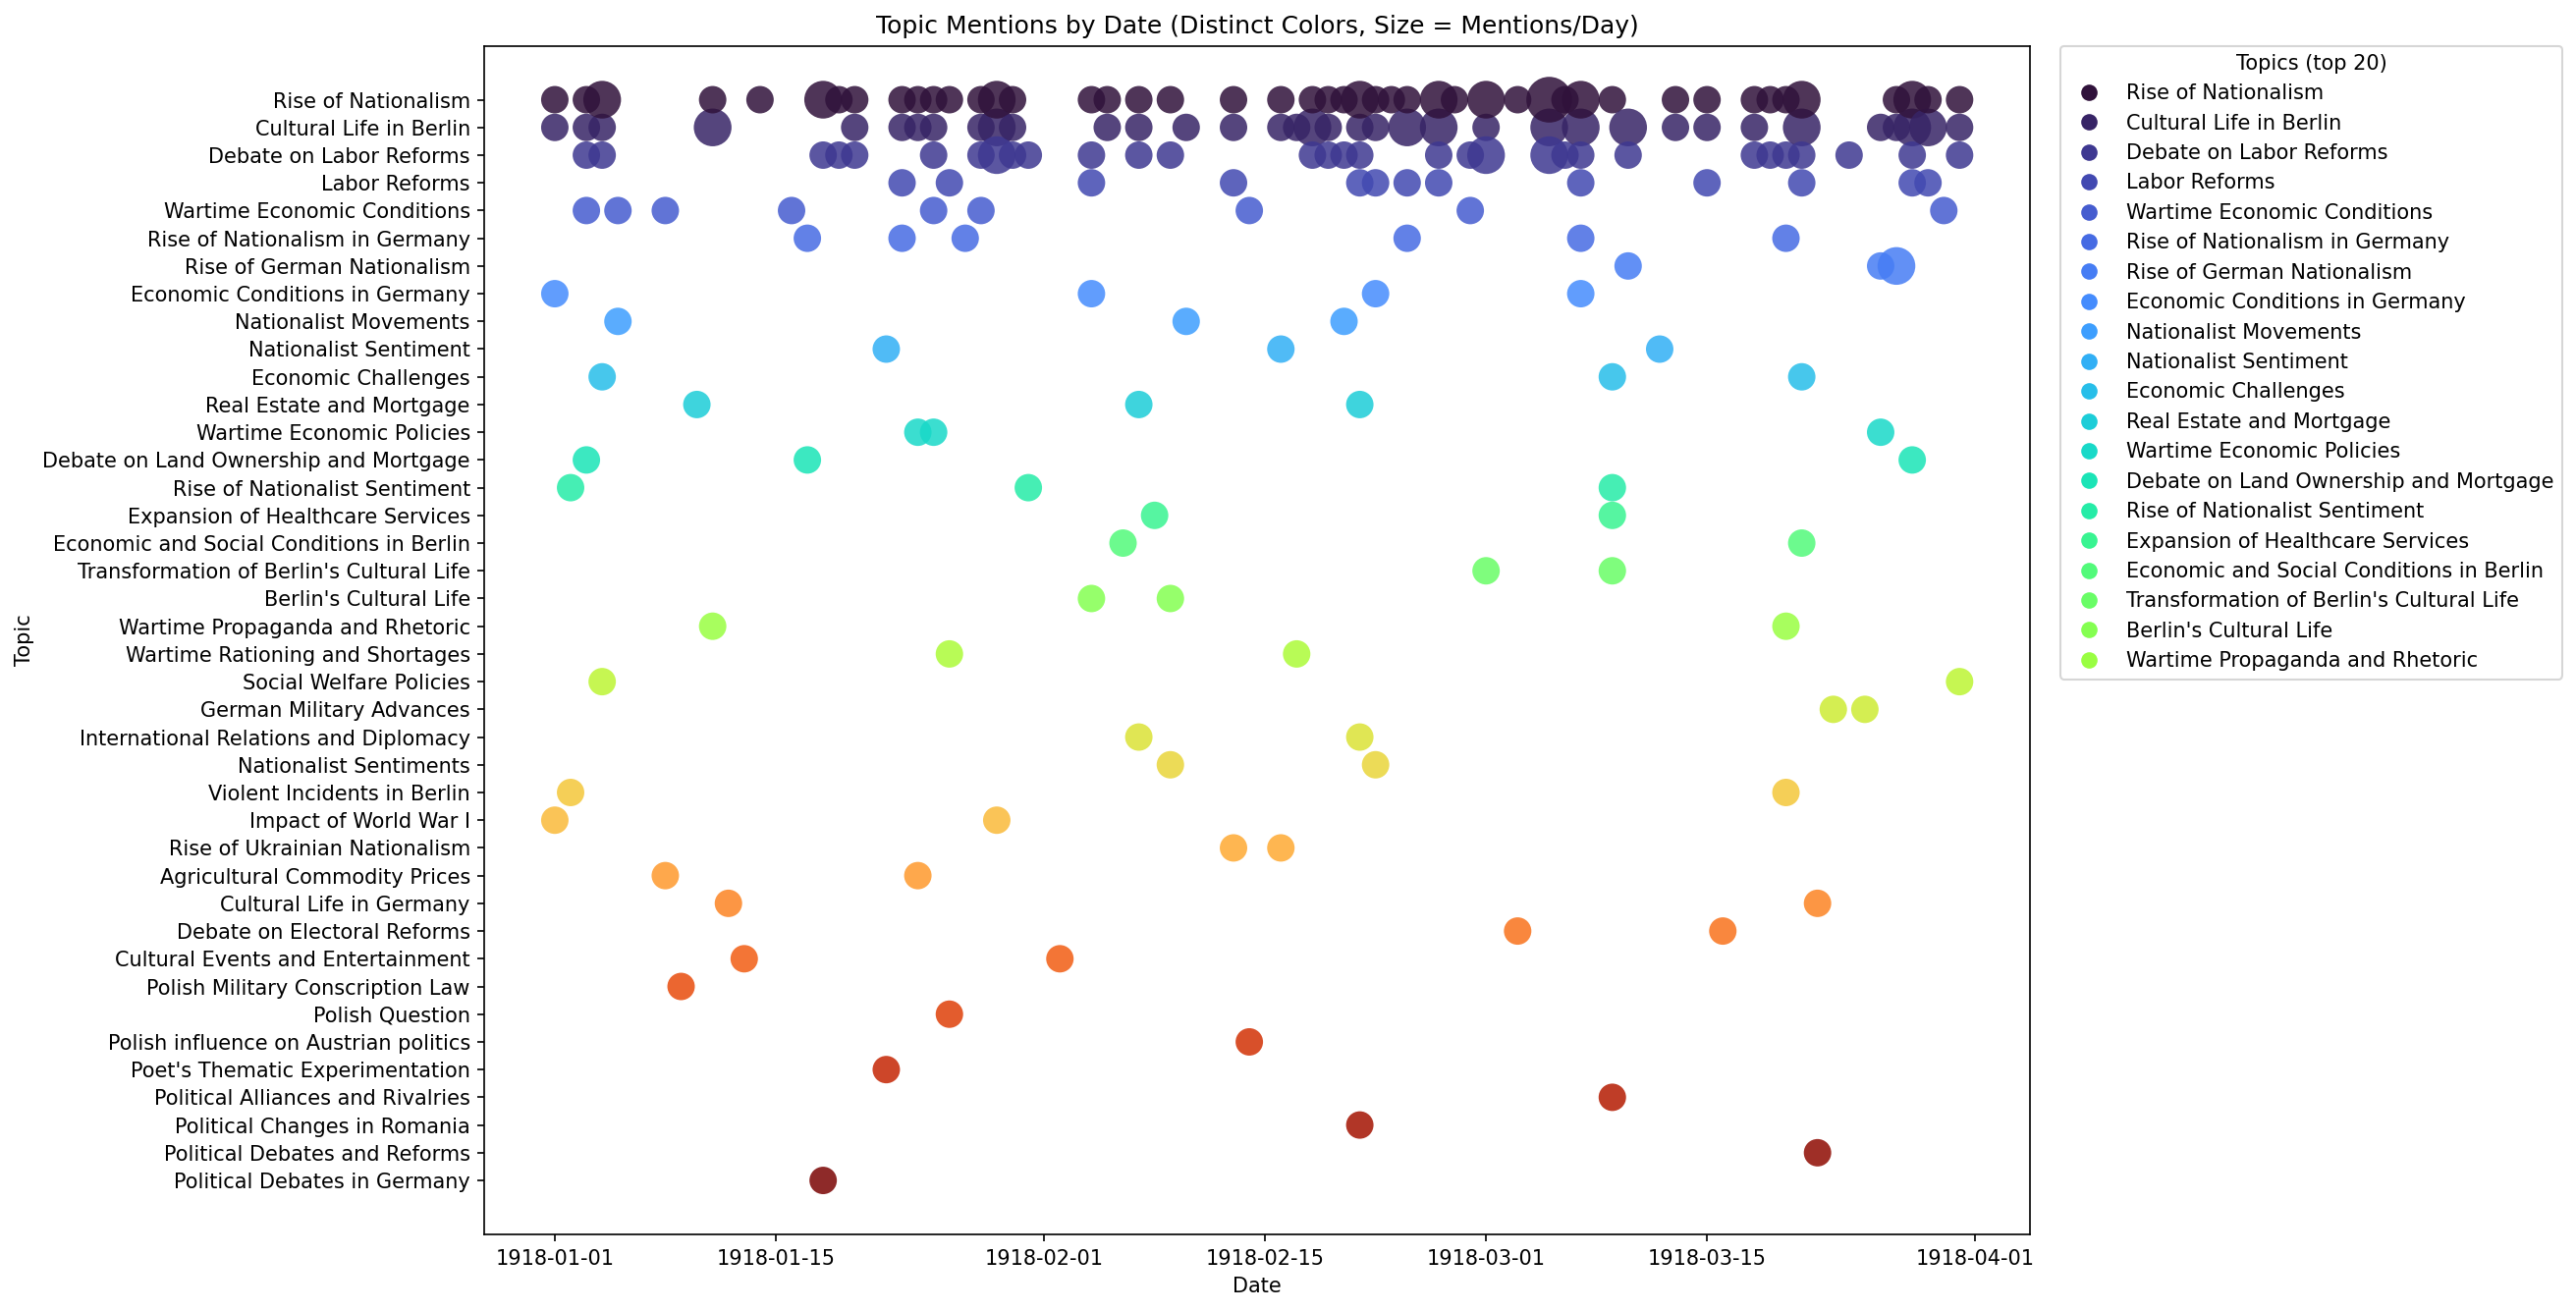

In [16]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.lines import Line2D
import numpy as np

# Optional filters
MIN_TOTAL_MENTIONS = 1
TOP_N = 40

topic_totals = summary.groupby("topic")["count"].sum().sort_values(ascending=False)
summary_plot = summary[summary["topic"].isin(topic_totals[topic_totals >= MIN_TOTAL_MENTIONS].index)].copy() \
               if MIN_TOTAL_MENTIONS > 1 else summary.copy()

if TOP_N is not None:
    keep = topic_totals.head(TOP_N).index
    summary_plot = summary_plot[summary_plot["topic"].isin(keep)].copy()
    topic_totals = topic_totals.loc[keep]

if summary_plot.empty:
    raise ValueError("No data left to plot after filtering.")

topics_ordered = list(topic_totals.index)
topic_to_y   = {t: i for i, t in enumerate(reversed(topics_ordered), start=1)}
topic_to_idx = {t: i for i, t in enumerate(topics_ordered)}

summary_plot["y"] = summary_plot["topic"].map(topic_to_y)
summary_plot["color_idx"] = summary_plot["topic"].map(topic_to_idx)

# Size: scaled by count
sizes = summary_plot["count"].astype(float)
s = (sizes / sizes.max()) * 480.0 + 20.0

# ---- DISTINCT COLORS ----
num_topics = len(topics_ordered)
# Choose palette dynamically
if num_topics <= 10:
    cmap = get_cmap("tab10")
elif num_topics <= 20:
    cmap = get_cmap("tab20")
elif num_topics <= 256:
    cmap = get_cmap("turbo")        # vivid rainbow
else:
    cmap = get_cmap("nipy_spectral") # fallback for huge numbers
# Normalize evenly spaced color values
color_values = np.linspace(0, 1, num_topics)
topic_to_color = {t: cmap(color_values[i]) for i, t in enumerate(topics_ordered)}
summary_plot["color"] = summary_plot["topic"].map(topic_to_color)

# ---- PLOT ----
plt.figure(figsize=(14, 9), dpi=150)
plt.scatter(
    summary_plot["date"],
    summary_plot["y"],
    c=summary_plot["color"],
    s=s,
    alpha=0.85,
    edgecolors="none"
)

# Y-axis topics
y_ticks = sorted(set(summary_plot["y"]))
inv_map = {v: k for k, v in topic_to_y.items()}
plt.yticks(y_ticks, [inv_map[i] for i in y_ticks])

plt.xlabel("Date")
plt.ylabel("Topic")
plt.title("Topic Mentions by Date (Distinct Colors, Size = Mentions/Day)")
plt.tight_layout()

# ---- LEGEND ----
LEGEND_MAX = 20
legend_topics = topics_ordered[:LEGEND_MAX]
handles = [
    Line2D([0], [0], marker='o', linestyle='',
           markersize=8, markeredgecolor='none',
           markerfacecolor=topic_to_color[t],
           label=t)
    for t in legend_topics
]
plt.legend(
    handles=handles,
    title=f"Topics (top {min(LEGEND_MAX, len(legend_topics))})",
    bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.
)

plt.show()


In [ ]:
# issues_topics_openrouter.py
# Topic modeling per issue (.txt) -> CSV, using BERTopic + OpenRouter (OpenAI-compatible) for topic labels.

from pathlib import Path
import re
import os
import pandas as pd
from tqdm import tqdm

from bertopic import BERTopic
from bertopic.representation import OpenAI as OpenAIRepresentation
from openai import OpenAI

from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

# ======================== CONFIG ========================
EXPORTS_ROOT = Path("/home/acr1408/projects/portafolio/der_tag/trial/dertag_1918-1920/exports")
CSV_OUT      = EXPORTS_ROOT / "issues_topics_llm.csv"

# OpenRouter model + auth (set env vars before running)
# Recommended example: export OPENROUTER_MODEL="anthropic/claude-3-haiku"
OPENROUTER_MODEL   = os.getenv("OPENROUTER_MODEL", "anthropic/claude-3-haiku")
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY", "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")

# Label generation budget (short labels -> cheap & fast)
# (Mapped into OpenAIRepresentation's generation_kwargs)
GENERATION_KW = dict(
    temperature=0.6,
    top_p=0.95,
    max_tokens=32,
)

# How many topic words & representative docs to feed into the label prompt
N_TOPIC_WORDS     = 8
N_REP_DOCS        = 3
DOC_LENGTH_WORDS  = 64   # how many words BERTopic will feed per representative doc

# ======================== HELPERS ========================
def parse_issue_from_path(p: Path):
    """Parse YYYY-MM-DD-iII from filename and year/month from dirs if present."""
    m = re.search(r"(?P<y>\d{4})-(?P<m>\d{2})-(?P<d>\d{2})-i(?P<i>\d+)\.txt$", p.name)
    if m:
        return m.group("y"), m.group("m"), m.group("d"), m.group("i")
    parts = p.parts
    year = next((x for x in parts if re.fullmatch(r"\d{4}", x)), "")
    month = next((x for x in parts if re.fullmatch(r"\d{2}", x)), "")
    daym = re.search(r"\d{4}-(\d{2})-(\d{2})", p.name)
    day  = daym.group(2) if daym else ""
    issue = (re.search(r"-i(\d+)", p.name) or re.search(r"i(\d+)", p.name) or [None, ""])[1]
    return year, month, day, issue

def split_into_docs(raw_text: str):
    """
    Chunk an issue into smaller docs for BERTopic.
    Prefer page headers '=== PAGE N ===', else split on blank lines,
    then fall back to sentence windows. Filters tiny chunks.
    """
    if "=== PAGE" in raw_text:
        chunks = re.split(r"^=== PAGE .*?===$", raw_text, flags=re.MULTILINE)
    else:
        chunks = re.split(r"\n\s*\n", raw_text)

    docs = [re.sub(r"\s+", " ", c).strip() for c in chunks]
    docs = [d for d in docs if len(d) >= 200]

    if len(docs) < 5:
        sents = re.split(r"(?<=[.!?])\s+", raw_text)
        window, step = 5, 5
        docs = []
        for i in range(0, len(sents), step):
            piece = " ".join(sents[i:i+window]).strip()
            if len(piece) >= 150:
                docs.append(piece)
    return docs

def label_from_topic_words(topic_words, top_k=2):
    """Convert list[(word, score), ...] to a compact label like 'krieg politik'."""
    if not topic_words:
        return ""
    return " ".join([w for (w, _) in topic_words[:top_k]])

def fallback_keywords(text, top_k=5):
    """Simple fallback when no topics/labels can be formed."""
    cv = CountVectorizer(stop_words=None, ngram_range=(1, 2), min_df=2)
    try:
        X = cv.fit_transform([text])
        vocab = cv.get_feature_names_out()
        counts = X.toarray().sum(axis=0)
        pairs = sorted(zip(vocab, counts), key=lambda t: t[1], reverse=True)
        return [w for w, _ in pairs[:top_k]]
    except Exception:
        return []

# ======================== Historian prompt (yours) ========================
# BERTopic will fill [KEYWORDS] and [DOCUMENTS] into this prompt
LLM_PROMPT = (
    "You are a historian researcher analyzing German newspapers published between 1900 and 1934. "
    "Your task is to extract the main historical topics discussed in the issue.\n\n"
    "Instructions:\n"
    "1. Identify all relevant historical themes (political, social, cultural, economic, or international).\n"
    "2. Extract at least 5 distinct topics that best represent the newspaper’s content.\n"
    "3. Even if the text is in German, write the extracted topics clearly in English.\n"
    "4. Each topic should be concise (3–5 words) and reflect historically meaningful subjects — "
    "not just keywords.\n"
    "5. Examples: 'Debate on Labor Reforms', 'Rise of Nationalism', 'Cultural Life in Berlin'.\n\n"
    "Keywords: [KEYWORDS]\n"
    "Documents: [DOCUMENTS]\n\n"
    "Extracted Topics (in English):"
)

# ======================== OpenRouter via OpenAI-compatible client ========================
representation_model = None
try:
    if not OPENROUTER_API_KEY:
        raise RuntimeError("OPENROUTER_API_KEY not set. Export it in your environment.")

    # OpenAI client pointed at OpenRouter (OpenAI-compatible)
    client = OpenAI(
        base_url="https://openrouter.ai/api/v1",
        api_key=OPENROUTER_API_KEY,
    )

    # BERTopic's OpenAI representation (works with any OpenAI-compatible client)
    representation_model = OpenAIRepresentation(
        client=client,
        model=OPENROUTER_MODEL,   # e.g., "anthropic/claude-3-haiku" or "mistralai/mistral-small-2409"
        chat=True,                # use chat completions
        prompt=LLM_PROMPT,
        nr_docs=N_REP_DOCS,
        doc_length=DOC_LENGTH_WORDS,
        tokenizer="whitespace",
        generation_kwargs=GENERATION_KW,
    )
except Exception as e:
    print(
        f"⚠️ Could not initialize OpenRouter generator: {e}\n"
        f"   Will fall back to non-LLM labels."
    )

# ======================== BERTopic core ========================
# Multilingual, small and CPU friendly embeddings for clustering
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# Keep stop_words=None (avoid sklearn language strings that can error)
vectorizer_model = CountVectorizer(stop_words=None, ngram_range=(1, 2), min_df=2)

# ======================== Main loop ========================
txt_paths = sorted(EXPORTS_ROOT.rglob("*.txt"))
if not txt_paths:
    raise FileNotFoundError(f"No .txt issues found under: {EXPORTS_ROOT}")

rows = []

for p in tqdm(txt_paths, desc="Topic modeling per issue"):
    year, month, day, issue = parse_issue_from_path(p)
    text = p.read_text(encoding="utf-8", errors="ignore")
    docs = split_into_docs(text)

    if len(docs) < 2:
        topics = fallback_keywords(text, top_k=5)
        subtopics = topics[:5]
        rows.append({
            "year": year, "month": month, "day": day, "issue": issue,
            "topics": "|".join(topics),
            "subtopics": "|".join(subtopics),
            "path": str(p)
        })
        continue

    topic_model = BERTopic(
        embedding_model=embedding_model,
        vectorizer_model=vectorizer_model,
        min_topic_size=5,
        representation_model=representation_model,  # may be None -> BERTopic defaults to KeyBERT-inspired labels
        nr_topics=None,
        calculate_probabilities=False,
        verbose=False
    )

    topics, _ = topic_model.fit_transform(docs)

    info = topic_model.get_topic_info()
    info = info[info["Topic"] != -1].sort_values("Count", ascending=False)

    if info.empty:
        top = fallback_keywords(text, top_k=5)
        rows.append({
            "year": year, "month": month, "day": day, "issue": issue,
            "topics": "|".join(top),
            "subtopics": "|".join(top),
            "path": str(p)
        })
        continue

    top_topic_ids = info["Topic"].head(5).tolist()
    topic_labels = []
    for tid in top_topic_ids:
        words_scores = (topic_model.get_topic(tid) or [])  # [(word, score), ...]
        # If OpenRouter is inactive, fall back to word-based label
        if not representation_model:
            topic_labels.append(label_from_topic_words(words_scores, top_k=2))
        else:
            try:
                rep = topic_model.get_topic_repr()[tid]
                # BERTopic stores list of strings (best label first)
                if isinstance(rep, list) and rep:
                    label = rep[0]
                else:
                    label = None
                if not label or not isinstance(label, str) or not label.strip():
                    label = label_from_topic_words(words_scores, top_k=2)
                topic_labels.append(label)
            except Exception:
                topic_labels.append(label_from_topic_words(words_scores, top_k=2))

    # Sub-topics = top 5 words of the dominant topic (+ pad from others)
    dominant_tid = top_topic_ids[0]
    dominant_words = [w for (w, _) in (topic_model.get_topic(dominant_tid) or [])][:5]
    if len(dominant_words) < 5:
        for tid in top_topic_ids[1:]:
            extras = [w for (w, _) in (topic_model.get_topic(tid) or [])]
            for w in extras:
                if w not in dominant_words:
                    dominant_words.append(w)
                if len(dominant_words) >= 5:
                    break
            if len(dominant_words) >= 5:
                break
    if not dominant_words:
        dominant_words = fallback_keywords(text, top_k=5)

    rows.append({
        "year": year, "month": month, "day": day, "issue": issue,
        "topics": "|".join(topic_labels[:5]),
        "subtopics": "|".join(dominant_words[:5]),
        "path": str(p)
    })

df = pd.DataFrame(rows, columns=["year", "month", "day", "issue", "topics", "subtopics", "path"])
df.sort_values(["year", "month", "day", "issue"], inplace=True)
df.to_csv(CSV_OUT, index=False, encoding="utf-8")
print(f"✅ Wrote topics CSV -> {CSV_OUT}")


Topic modeling per issue:   2%|█▎                                                         | 5/235 [02:22<1:26:52, 22.66s/it]

In [ ]:
##ACR: I stopped this after 50mins and 94/235 iterations. It seemed to be working but too slow
#
## issues_topics_hf_germangpt2.py
## Topic modeling per issue (.txt) -> CSV, using BERTopic + a tiny HF pipeline (German GPT-2) for labels.
#
#from pathlib import Path
#import re
#import os
#import pandas as pd
#from tqdm import tqdm
#
#from bertopic import BERTopic
#from bertopic.representation import TextGeneration
#from sentence_transformers import SentenceTransformer
#from sklearn.feature_extraction.text import CountVectorizer
#
#from transformers import pipeline
#
## ======================== CONFIG ========================
#EXPORTS_ROOT = Path("/home/acr1408/projects/portafolio/der_tag/trial/dertag_1918-1920/exports")
#CSV_OUT      = EXPORTS_ROOT / "issues_topics_llm.csv"
#
## Small, public German causal LM (CPU-friendly)
## Context is ~1024 tokens; we keep prompts tiny.
#HF_LABEL_MODEL = "dbmdz/german-gpt2"
#
## Label generation budget (short labels -> cheap & fast)
#PIPELINE_KW = dict(
#    max_new_tokens=32,
#    do_sample=False,
#    temperature=0.6,
#    top_p=0.95,
#    repetition_penalty=1.1,
#)
#
## How many topic words & representative docs to feed into the label prompt
#N_TOPIC_WORDS   = 8
#N_REP_DOCS      = 3
#DOC_LENGTH_WORDS = 64   # how many words BERTopic will feed per representative doc
#
## ======================== HELPERS ========================
#def parse_issue_from_path(p: Path):
#    """Parse YYYY-MM-DD-iII from filename and year/month from dirs if present."""
#    m = re.search(r"(?P<y>\d{4})-(?P<m>\d{2})-(?P<d>\d{2})-i(?P<i>\d+)\.txt$", p.name)
#    if m:
#        return m.group("y"), m.group("m"), m.group("d"), m.group("i")
#    parts = p.parts
#    year = next((x for x in parts if re.fullmatch(r"\d{4}", x)), "")
#    month = next((x for x in parts if re.fullmatch(r"\d{2}", x)), "")
#    daym = re.search(r"\d{4}-(\d{2})-(\d{2})", p.name)
#    day  = daym.group(2) if daym else ""
#    issue = (re.search(r"-i(\d+)", p.name) or re.search(r"i(\d+)", p.name) or [None, ""])[1]
#    return year, month, day, issue
#
#def split_into_docs(raw_text: str):
#    """
#    Chunk an issue into smaller docs for BERTopic.
#    Prefer page headers '=== PAGE N ===', else split on blank lines,
#    then fall back to sentence windows. Filters tiny chunks.
#    """
#    if "=== PAGE" in raw_text:
#        chunks = re.split(r"^=== PAGE .*?===$", raw_text, flags=re.MULTILINE)
#    else:
#        chunks = re.split(r"\n\s*\n", raw_text)
#
#    docs = [re.sub(r"\s+", " ", c).strip() for c in chunks]
#    docs = [d for d in docs if len(d) >= 200]
#
#    if len(docs) < 5:
#        sents = re.split(r"(?<=[.!?])\s+", raw_text)
#        window, step = 5, 5
#        docs = []
#        for i in range(0, len(sents), step):
#            piece = " ".join(sents[i:i+window]).strip()
#            if len(piece) >= 150:
#                docs.append(piece)
#    return docs
#
#def label_from_topic_words(topic_words, top_k=2):
#    """Convert list[(word, score), ...] to a compact label like 'krieg politik'."""
#    if not topic_words:
#        return ""
#    return " ".join([w for (w, _) in topic_words[:top_k]])
#
#def fallback_keywords(text, top_k=5):
#    """Simple fallback when no topics/labels can be formed."""
#    cv = CountVectorizer(stop_words=None, ngram_range=(1, 2), min_df=2)
#    try:
#        X = cv.fit_transform([text])
#        vocab = cv.get_feature_names_out()
#        counts = X.toarray().sum(axis=0)
#        pairs = sorted(zip(vocab, counts), key=lambda t: t[1], reverse=True)
#        return [w for w, _ in pairs[:top_k]]
#    except Exception:
#        return []
#
## ======================== HF PIPELINE (German GPT-2) ========================
#gen_pipe = None
#try:
#    # CPU only
#    gen_pipe = pipeline("text-generation", model=HF_LABEL_MODEL, tokenizer=HF_LABEL_MODEL, device=-1)
#except Exception as e:
#    print(f"⚠️ Could not load HF pipeline '{HF_LABEL_MODEL}': {e}\n"
#          f"   Will fall back to non-LLM labels.")
#
## BERTopic will fill [KEYWORDS] and [DOCUMENTS] into this prompt
#LLM_PROMPT = (
#    "Schreibe eine sehr kurze Themenbezeichnung (3–5 Wörter) auf Deutsch, "
#    "basierend auf diesen Schlüsselwörtern und Belegtexten.\n"
#    "Schlüsselwörter: [KEYWORDS]\n"
#    "Belegtexte: [DOCUMENTS]\n"
#    "Themenbezeichnung:"
#)
#
#representation_model = None
#if gen_pipe is not None:
#    # This is the crucial fix: pass a HF *pipeline* (or a model id string), not a custom callable
#    representation_model = TextGeneration(
#        gen_pipe,
#        prompt=LLM_PROMPT,
#        pipeline_kwargs=PIPELINE_KW,
#        nr_docs=N_REP_DOCS,
#        doc_length=DOC_LENGTH_WORDS,
#        tokenizer="whitespace"
#    )
#
## ======================== BERTopic core ========================
## Multilingual, small and CPU friendly embeddings for clustering
#embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
#
## Keep stop_words=None (avoid sklearn language strings that can error)
#vectorizer_model = CountVectorizer(stop_words=None, ngram_range=(1, 2), min_df=2)
#
## ======================== Main loop ========================
#txt_paths = sorted(EXPORTS_ROOT.rglob("*.txt"))
#if not txt_paths:
#    raise FileNotFoundError(f"No .txt issues found under: {EXPORTS_ROOT}")
#
#rows = []
#
#for p in tqdm(txt_paths, desc="Topic modeling per issue"):
#    year, month, day, issue = parse_issue_from_path(p)
#    text = p.read_text(encoding="utf-8", errors="ignore")
#    docs = split_into_docs(text)
#
#    if len(docs) < 2:
#        topics = fallback_keywords(text, top_k=5)
#        subtopics = topics[:5]
#        rows.append({
#            "year": year, "month": month, "day": day, "issue": issue,
#            "topics": "|".join(topics),
#            "subtopics": "|".join(subtopics),
#            "path": str(p)
#        })
#        continue
#
#    topic_model = BERTopic(
#        embedding_model=embedding_model,
#        vectorizer_model=vectorizer_model,
#        min_topic_size=5,
#        representation_model=representation_model,  # may be None -> BERTopic defaults to KeyBERT-inspired labels
#        nr_topics=None,
#        calculate_probabilities=False,
#        verbose=False
#    )
#
#    topics, _ = topic_model.fit_transform(docs)
#
#    info = topic_model.get_topic_info()
#    info = info[info["Topic"] != -1].sort_values("Count", ascending=False)
#
#    if info.empty:
#        top = fallback_keywords(text, top_k=5)
#        rows.append({
#            "year": year, "month": month, "day": day, "issue": issue,
#            "topics": "|".join(top),
#            "subtopics": "|".join(top),
#            "path": str(p)
#        })
#        continue
#
#    top_topic_ids = info["Topic"].head(5).tolist()
#    topic_labels = []
#    for tid in top_topic_ids:
#        words_scores = (topic_model.get_topic(tid) or [])  # [(word, score), ...]
#        # If HF pipeline loaded, TextGeneration will already generate labels inside BERTopic
#        # But we also build a robust fallback:
#        if not representation_model:
#            topic_labels.append(label_from_topic_words(words_scores, top_k=2))
#        else:
#            # Get the label BERTopic generated (stored in topic_model.topic_representations_)
#            # If not present, fallback to word-based label.
#            try:
#                rep = topic_model.get_topic_repr()[tid]
#                label = rep[0] if isinstance(rep, list) and rep else None
#                if not label or not isinstance(label, str):
#                    label = label_from_topic_words(words_scores, top_k=2)
#                topic_labels.append(label)
#            except Exception:
#                topic_labels.append(label_from_topic_words(words_scores, top_k=2))
#
#    # Sub-topics = top 5 words of the dominant topic (+ pad from others)
#    dominant_tid = top_topic_ids[0]
#    dominant_words = [w for (w, _) in (topic_model.get_topic(dominant_tid) or [])][:5]
#    if len(dominant_words) < 5:
#        for tid in top_topic_ids[1:]:
#            extras = [w for (w, _) in (topic_model.get_topic(tid) or [])]
#            for w in extras:
#                if w not in dominant_words:
#                    dominant_words.append(w)
#                if len(dominant_words) >= 5:
#                    break
#            if len(dominant_words) >= 5:
#                break
#    if not dominant_words:
#        dominant_words = fallback_keywords(text, top_k=5)
#
#    rows.append({
#        "year": year, "month": month, "day": day, "issue": issue,
#        "topics": "|".join(topic_labels[:5]),
#        "subtopics": "|".join(dominant_words[:5]),
#        "path": str(p)
#    })
#
#df = pd.DataFrame(rows, columns=["year", "month", "day", "issue", "topics", "subtopics", "path"])
#df.sort_values(["year", "month", "day", "issue"], inplace=True)
#df.to_csv(CSV_OUT, index=False, encoding="utf-8")
#print(f"✅ Wrote topics CSV -> {CSV_OUT}")
#

Read and preview one exported text

In [ ]:
#from pathlib import Path
#
## Path to your exported text file
#file_path = Path("/home/acr1408/projects/portafolio/der_tag/data/dertag_1918-1920/exports/1918-01-01-i01.txt")
#
## Verify it exists
#if not file_path.exists():
#    raise FileNotFoundError(f"File not found: {file_path}")
#
## Read entire contents
#text = file_path.read_text(encoding="utf-8")
#
## Show basic info
#print(f"✅ Loaded file: {file_path}")
#print(f"Total characters: {len(text):,}")
#print(f"Total lines: {len(text.splitlines()):,}")
#
## Preview first few lines
#print("\n--- Preview ---")
#print("\n".join(text.splitlines()[:20]))
